In [1]:
import math
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from typing import Tuple
from pathlib import Path
from tqdm.auto import tqdm

# Add parent directory to path
sys.path.insert(0, "../..")

from hira.index.indexer import CPUIndexer
from hira.index.searcher import CPUSearcher
from hira.benchmark_area.utils.data_loader import get_real_data

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/mohsen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# configs
CONFIG = {
    "initial_keys": 10000,
    "new_keys": 80000,
    "branching_factors": [8, 16, 32, 64],
    "distributions": ["real"],  # , "uniform", "mixture_of_gaussians", "zipf"],
    "search_chunk_size": 8 * 1024,
    "dim": 128,
    "device": "cpu",
    "target_results": 10,
    "max_iterations": 1,
    "seed": 42,
    "num_runs": 5,  # Number of times to run each experiment
    "real_data_path": "../kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz",
    "output_csv": "cpu_ab_test_results.csv",
    "window_sizes": [16, 32, 64, 128, 256, 512, 1024],
}

In [ ]:
def run_benchmark(
    initial_keys: torch.Tensor,
    next_keys: torch.Tensor,
    window_size: int,
    branching_factor: int,
    device: str,
    max_iterations: int,
) -> Tuple[float, float, float, float, float, float, float, float]:
    initial_keys = initial_keys.to(device)
    next_keys = next_keys.to(device)

    # Calculate number of levels
    # TODO: here I used length of initial keys
    num_levels = math.ceil(math.log(len(initial_keys)) / math.log(branching_factor))

    # Build index (only once)
    config = {
        "num_levels": num_levels,
        "branching_factor": branching_factor,
        "max_iterations": max_iterations,
    }
    index_true = CPUIndexer(**config)
    index_true.build(initial_keys)

    index_false = CPUIndexer(**config)
    index_false.build(initial_keys)

    build_times_true = []
    build_times_false = []

    # break next_keys into chunks of size window_size
    chunks = [
        next_keys[i : i + window_size]
        for i in range(0, next_keys.shape[0], window_size)
    ]

    for chunk in tqdm(chunks, desc="Updating with fast=True"):
        # Time the update operation
        start_time = time.time()
        index_true.update(chunk, fast=True)
        end_time = time.time()
        build_times_true.append(end_time - start_time)

    avg_build_time_true = sum(build_times_true) / len(build_times_true)

    for chunk in tqdm(chunks, desc="Updating with fast=False"):
        # Time the update operation
        start_time = time.time()
        index_false.update(chunk, fast=False)
        end_time = time.time()
        build_times_false.append(end_time - start_time)

    avg_build_time_false = sum(build_times_false) / len(build_times_false)

    return avg_build_time_true, avg_build_time_false


print("functions defined!")

functions defined!


In [ ]:
%%time

results = []
output_csv = Path(CONFIG['output_csv'])

# Load keys
fixed_keys = get_real_data(
    CONFIG["initial_keys"] + CONFIG["new_keys"],
    CONFIG['dim'],
    seed=CONFIG['seed'],
    real_data_path=CONFIG['real_data_path']
)

for branching_factor in CONFIG['branching_factors']:
    print(f"\n  BF: {branching_factor:,}")
    
    initial_keys = fixed_keys[:CONFIG["initial_keys"]]
    next_keys = fixed_keys[CONFIG["initial_keys"]:]
    
    for window_size in CONFIG['window_sizes']:
        print(f"    Window Size: {window_size:,}")
        
        for _ in range(CONFIG["num_runs"]):
            build_time_true, build_time_false = run_benchmark(
                initial_keys,
                next_keys,
                window_size,
                branching_factor,
                CONFIG['device'],
                CONFIG['max_iterations'],
            )
        
            result = {
                'branching_factor': branching_factor,
                'window_size': window_size,
                'build_time_true': build_time_true,
                'build_time_false': build_time_false,
            }
            
            results.append(result)
        
        # Save intermediate results to CSV after each experiment
        pd.DataFrame(results).to_csv(output_csv, index=False)

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(f"\nResults saved to: {output_csv.absolute()}")

### Visual

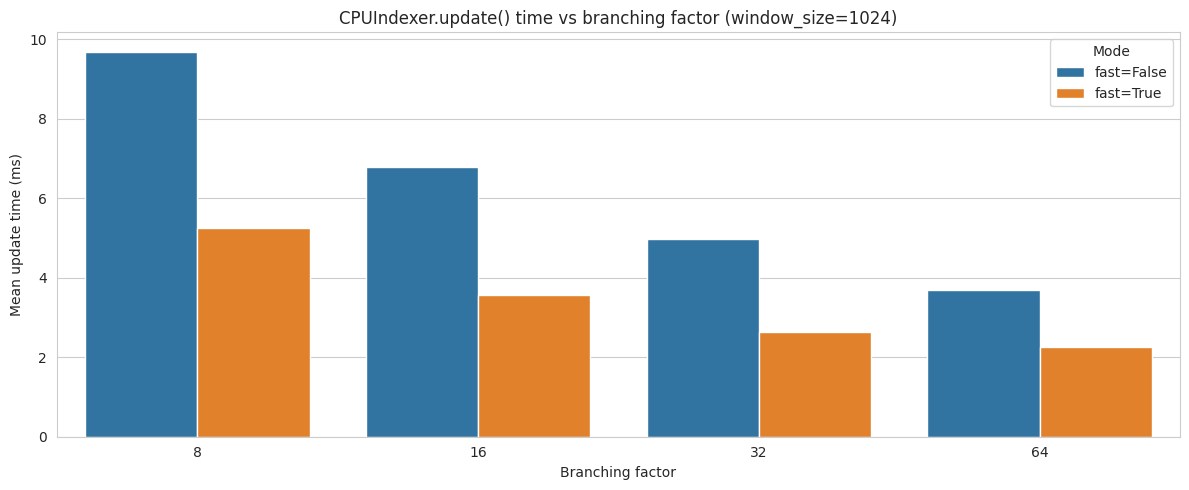

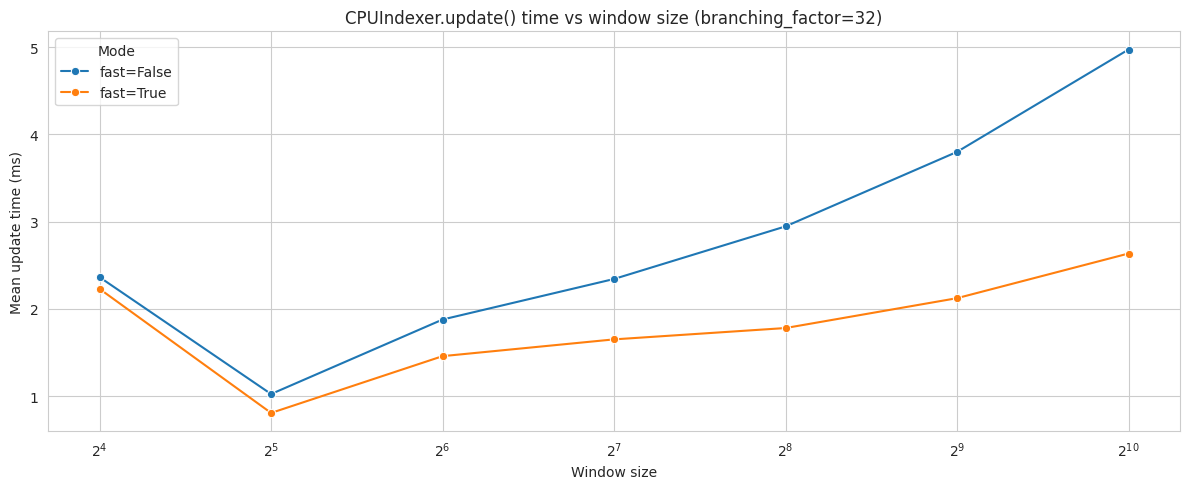

Tip: set `bf_plot_window_size` and `fixed_bf` to focus the plots.


In [5]:
# Visualize benchmark results
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

csv_path = Path(CONFIG.get("output_csv", "cpu_ab_test_results.csv"))
df = pd.read_csv(csv_path)

# Ensure numeric types
for c in ["branching_factor", "window_size", "build_time_true", "build_time_false"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(
    subset=["branching_factor", "window_size", "build_time_true", "build_time_false"]
).copy()

# Long-form for plotting
long = df.melt(
    id_vars=["branching_factor", "window_size"],
    value_vars=["build_time_true", "build_time_false"],
    var_name="mode",
    value_name="time_s",
)
long["mode"] = long["mode"].map(
    {"build_time_true": "fast=True", "build_time_false": "fast=False"}
)
long["time_ms"] = long["time_s"] * 1e3

# Aggregate across runs
agg = long.groupby(["branching_factor", "window_size", "mode"], as_index=False).agg(
    mean_ms=("time_ms", "mean"), std_ms=("time_ms", "std"), n=("time_ms", "size")
)

# -----------------------------
# Plot 1: Compare by branching factor (choose a window_size)
# -----------------------------
# Pick a representative window size (override as desired)
bf_plot_window_size = 1024
bf_view = agg[agg["window_size"] == bf_plot_window_size].copy()

plt.figure(figsize=(12, 5))
sns.barplot(
    data=bf_view,
    x="branching_factor",
    y="mean_ms",
    hue="mode",
    errorbar=None,
)
plt.title(
    f"CPUIndexer.update() time vs branching factor (window_size={bf_plot_window_size})"
)
plt.xlabel("Branching factor")
plt.ylabel("Mean update time (ms)")
plt.legend(title="Mode")
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: Compare by window size (choose a fixed branching_factor)
# -----------------------------
# Pick a fixed branching factor (override as desired)
fixed_bf = 32
win_view = agg[agg["branching_factor"] == fixed_bf].copy().sort_values("window_size")

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=win_view,
    x="window_size",
    y="mean_ms",
    hue="mode",
    marker="o",
)
plt.title(f"CPUIndexer.update() time vs window size (branching_factor={fixed_bf})")
plt.xlabel("Window size")
plt.ylabel("Mean update time (ms)")
plt.xscale("log", base=2)
plt.legend(title="Mode")
plt.tight_layout()
plt.show()

print("Tip: set `bf_plot_window_size` and `fixed_bf` to focus the plots.")

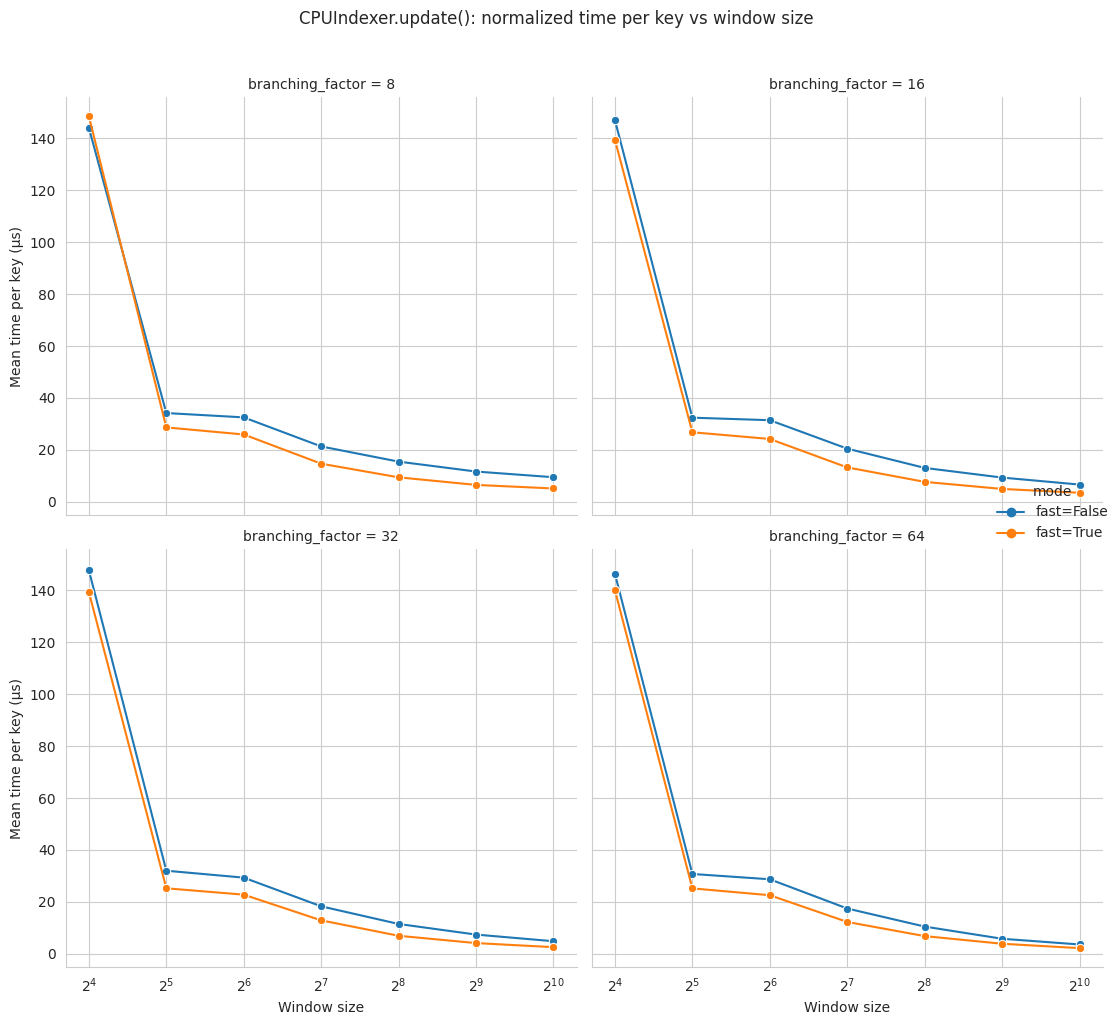

In [7]:
# -----------------------------
# Plot 3: Normalized time per key vs window size
# (time per key = mean update time / window_size)
# -----------------------------

# Compute microseconds per key for readability
norm = agg.copy()
norm["us_per_key"] = (norm["mean_ms"] * 1000.0) / norm["window_size"]

# Facet by branching factor to compare shapes
g = sns.relplot(
    data=norm.sort_values("window_size"),
    x="window_size",
    y="us_per_key",
    hue="mode",
    col="branching_factor",
    kind="line",
    marker="o",
    col_wrap=2,
    facet_kws={"sharex": True, "sharey": True},
)

# FacetGrid doesn't expose set_xscale; set it per-axis
for ax in g.axes.flat:
    try:
        ax.set_xscale("log", base=2)
    except TypeError:  # older matplotlib
        ax.set_xscale("log", basex=2)

g.set_axis_labels("Window size", "Mean time per key (µs)")
g.fig.suptitle("CPUIndexer.update(): normalized time per key vs window size", y=1.02)
plt.tight_layout()
plt.show()